In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from robocop import fetch_events,evaluate_and_report2,build_pid_windows,evaluate_and_report,build_pid_and_handle_windows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
NUM_SYSCALLS = 473 + 1 # State Of PADDING
PADDING_SYSCALL = 473
PADDING_OBJ = {'id': 0,
   'ts': 0,
   'pid': 0,
   'tid': 0,
   'syscall_num': PADDING_SYSCALL,
   'process_name': 0,
   'handle_operation': None,
   'handle_1_val': None,
   'handle_2_val': None,
   'ret_handle': None,
   'closed_handle': None,
   'handle_1_access': None,
   'handle_2_access': None,
   'handle_1_access_mode': None,
   'handle_2_access_mode': None,}
NGRAM = 4
NU = 0.01
GAMMA = 0.01

In [3]:
encoder = OneHotEncoder(
    categories=[np.arange(NUM_SYSCALLS)],
    sparse_output=False,
    handle_unknown="ignore"
)

# fit once
encoder.fit(np.zeros((1, 1), dtype=np.float64))




OneHotEncoder(categories=[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106...
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473])],
              handle_unknown='ignore', sparse_output=False)

 "NtAccessCheck": {"number": 0, "weight": 0.5, "type": "query", "cat": "security"},

In [929]:
import json 
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
# ────────────────────────────────────────────────
# Configuration
# ────────────────────────────────────────────────
NGRAM = 20

OPERATIONS_VECTORS = {
    "create":         np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "delete":         np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "write":          np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "query":          np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "wait":           np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "close":          np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "request":        np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "finish_mission": np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    "open":           np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    "set" :           np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    "schedulue":      np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    "error":          np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    "lock":           np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    "load":           np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    "flush":          np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    "ioctl":          np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
}
CATEGORIES_VECTORS = {
    "system_core":    np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "driver":         np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "system":         np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "memory_private": np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "memory_image":   np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "process":        np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "thread":         np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "fs":             np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "registry":       np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "security":       np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "sync":           np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    "alpc":           np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    "tx":             np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    "debug":          np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    "worker":         np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    "wnf":            np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    "job":            np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    "timing":         np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    "session":        np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
}



with open("windows_22h2_weights.json",'r') as file: 
    json_weights = json.load(file)

weights = { info["number"] : info["weight"] for name,info in json_weights.items() }
id_to_cat = {info["number"]: info["cat"] for name, info in json_weights.items()}
id_to_op_type = {info["number"]: info["type"] for name, info in json_weights.items()}

SYSTEM_PROCESSES = [
    "ows\\explorer.exe",
    "bem\\WmiPrvSE.exe",
    "perienceHost.exe",
    "em32\\consent.exe",
    "em32\\conhost.exe",
    "SysWOW64\\cmd.exe",
    "System32\\cmd.exe"
]

KERNEL_PROCESSES = [
    "System",
    "Registry"
]

CORE_PROCESSES = [
    "stem32\\lsass.exe",
    "tem32\\ctfmon.exe",
    "m32\\services.exe",
    "System32\\dwm.exe",
    "stem32\\csrss.exe",
    "em32\\wininit.exe",
     "m32\\winlogon.exe"
]

SERVICES = [
    "em32\\svchost.exe",
     "g\\Everything.exe",
     
]

BLOCK_PROCESSES = [
    "em32\\svchost.exe",
    "stem32\\lsass.exe",
    "tem32\\sihost.exe",
    "tem32\\ctfmon.exe",
    "ows\\explorer.exe",
    "stem32\\csrss.exe",
    "em32\\conhost.exe",
    "2\\sdiagnhost.exe",
    "32\\taskhostw.exe",
    "System32\\cmd.exe",
    "bem\\WmiPrvSE.exe",
    "m32\\services.exe",
    "SysWOW64\\cmd.exe",
    "System32\\dwm.exe",
]

HALF_AGGRESSIVE_OPERATION = ["create","set","lock","flush","load"]
AGRESSIVE_OPERATION = ["delete","write"]
REALY_AGGRESSIVE_OPERATION = ["schedulue","ioctl","error"]

def extract_features(window, open_reason_id, process_name):
    category_sum =np.zeros(19)
    total_weight = 0.0
    is_agressive = False
    realy_agressive = False
    half_aggressive = False
    handle_op_vector = np.zeros(16)
    syscall_sum = np.array([i for i,_ in window], dtype=np.int32).reshape(-1, 1)
    onehot = encoder.transform(syscall_sum)
    for syscall_id, _ in window:
        cat_name = id_to_cat.get(syscall_id, "system")
        category_sum += CATEGORIES_VECTORS.get(cat_name, np.zeros(19))
        total_weight += weights.get(syscall_id, 0.5)
        type_name = id_to_op_type.get(syscall_id, "query")
        
        if type_name in AGRESSIVE_OPERATION:
            is_agressive = True
        if type_name in HALF_AGGRESSIVE_OPERATION:
            half_aggressive = True
        if type_name in REALY_AGGRESSIVE_OPERATION:
            realy_agressive = True 
            
        handle_op_vector +=  OPERATIONS_VECTORS.get(type_name, np.zeros(16))

    if realy_agressive:
        total_weight *= 10**4
    if is_agressive:
        total_weight *= 20 # penlty for doing non novel operation(still intersting but less...)
    elif half_aggressive:
        total_weight *= 2
        
    real_times = [ts for _, ts in window if ts]
    duration = 0 
    mean_gap = 0 
    std_gap = 0
    if len(real_times) >= 2:
        gaps = np.diff(sorted(real_times))
        duration = gaps.sum()           # or real_times[-1] - real_times[0]
        mean_gap = gaps.mean()
        std_gap  = gaps.std()

    return np.concatenate([
        np.asarray(onehot.sum(axis=0),dtype=np.float64).ravel(),
        category_sum, 
        [np.log1p(1/(1+total_weight))], 
        [np.log1p(duration) , np.log1p(mean_gap) ,np.log1p(std_gap) ], 
        handle_op_vector,
    ])

def build_X(handles_seq, syscall_to_id=None): 
    vectors = [] 
    mapping = []  
    mappind_id = 0 
    process_name = None
    for handles in handles_seq:
        mappind_id +=1
        buf = []
        open_reason = 0 
        for handle in handles:
            process_name = handle["process_name"]
            if process_name in BLOCK_PROCESSES:
                break
            handle["id"] = mappind_id
            if handle["handle_operation"]:
                open_reason = handle["handle_operation"]
                
            if len(buf) == NGRAM: 
                vectors.append(extract_features(buf,open_reason,process_name))
                mapping.append(handles)  
                buf = buf[1:]
            buf.append((handle["syscall_num"],handle["ts"]))
        
        if len(buf) == NGRAM: 
            vectors.append(extract_features(buf,open_reason,process_name))
            mapping.append(handles)
        else:
            if buf:
                for i in range(NGRAM - len(buf)): 
                    buf.append((PADDING_SYSCALL,None))
                vectors.append(extract_features(buf,open_reason,process_name))
                mapping.append(handles)
    process_name = None


    return vectors, mapping   


In [5]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14' OR test='15' OR test='16' OR test='17'")

In [304]:
with open("data/train.json",'r') as data: 
    train_events = json.load(data)
train_events = train_events[:int(len(train_events) * 0.8)]
test_events = train_events[int(len(train_events) * 0.8):]

In [930]:
len(train_events)

684150

In [931]:
import robocop
from collections import defaultdict
def build_pid_and_handle_windows_set_and_weights(events):
    handle_pid_cache = defaultdict(lambda : (list(),list()))
    windows = []
    general_windows = [] 
    def extract_handles(e):
        handles = [] 
        if e["handle_1_val"]:
            yield e["handle_1_val"]
        if e["handle_2_val"]:
            yield e["handle_2_val"]
            
    for e in events:
        e['name'] = robocop.convert_syscall_num_to_string(e['syscall_num'])
        pid = e["pid"]
        
        if rh := e["ret_handle"]: 
            buf,cache = handle_pid_cache[(pid,rh)]
            #if (sn:=e["syscall_num"]) not in cache:
            buf.append(e)
                #cache.append(sn)
                
        for handle in extract_handles(e):
            buf,cache = handle_pid_cache[(pid,handle)]
            if buf or handle > 0x8000000000000000: 
                #if (sn:=e["syscall_num"]) not in cache:
                buf.append(e)
                    #cache.append(sn)
        
        if ch := e["closed_handle"]: 
            buf,cache = handle_pid_cache[(pid,ch)]
            if buf or handle > 0x8000000000000000:
                #if (sn:=e["syscall_num"]) not in cache:
                buf.append(e)
                    #cache.append(sn)
                windows.append(list(buf))
                cache.clear()
                buf.clear()

   #for ((proc,handle),group_self),cache in handle_pid_cache.items(): 
    #    if handle > 0x8000000000000000 and group_self: 
     #        windows.append(list(group_self))

    return windows

In [889]:
train_windows = build_pid_and_handle_windows_set_and_weights(train_events)

In [932]:
X_train,mapping = build_X(train_windows)


In [933]:
X_train[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [934]:
len(X_train)

19167

In [935]:
X_train[0].shape

(513,)

In [936]:
scaler = StandardScaler()
pca = PCA(n_components=2)
X_2d = pca.fit_transform(scaler.fit_transform(X_train))

In [14]:
virus_events = fetch_events("test = '8' OR test='5' OR test='10' OR test='9' OR test='12' OR test='11' OR test='4' OR test='7' OR test='6' OR test='13' OR test='3' ")


In [937]:
len(virus_events)

3993825

In [938]:
virus_windows = build_pid_and_handle_windows_set_and_weights(virus_events)
X_virus,virus_mapping = build_X(virus_windows)

In [939]:
normal_events = test_events

In [940]:
normal_windows = build_pid_and_handle_windows_set_and_weights(normal_events)
X_normal,normla_mapping= build_X(normal_windows)

In [900]:
len(virus_windows)/len(normal_windows)

22.450518457071755

In [941]:
len(normal_windows)

12055

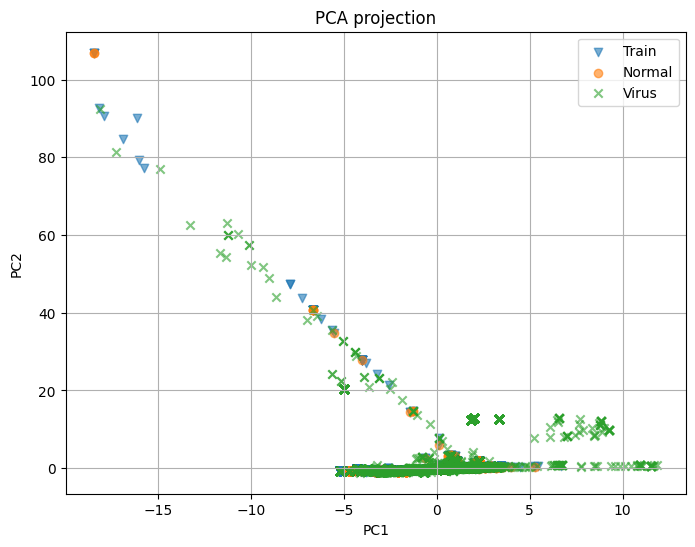

In [942]:
x_train_2d = X_2d
X_normal_2d = pca.transform(scaler.transform(X_normal))
X_virus_2d  = pca.transform(scaler.transform(X_virus))   # project to same PCA space

plt.figure(figsize=(8, 6))

plt.scatter(
    x_train_2d[:, 0], x_train_2d[:, 1],
    alpha=0.6, label="Train", marker="v"
)

plt.scatter(
    X_normal_2d[:, 0], X_normal_2d[:, 1],
    alpha=0.6, label="Normal", marker="o"
)

plt.scatter(
    X_virus_2d[:, 0], X_virus_2d[:, 1],
    alpha=0.6, label="Virus", marker="x"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection")
plt.legend()
plt.grid(True)

plt.show()

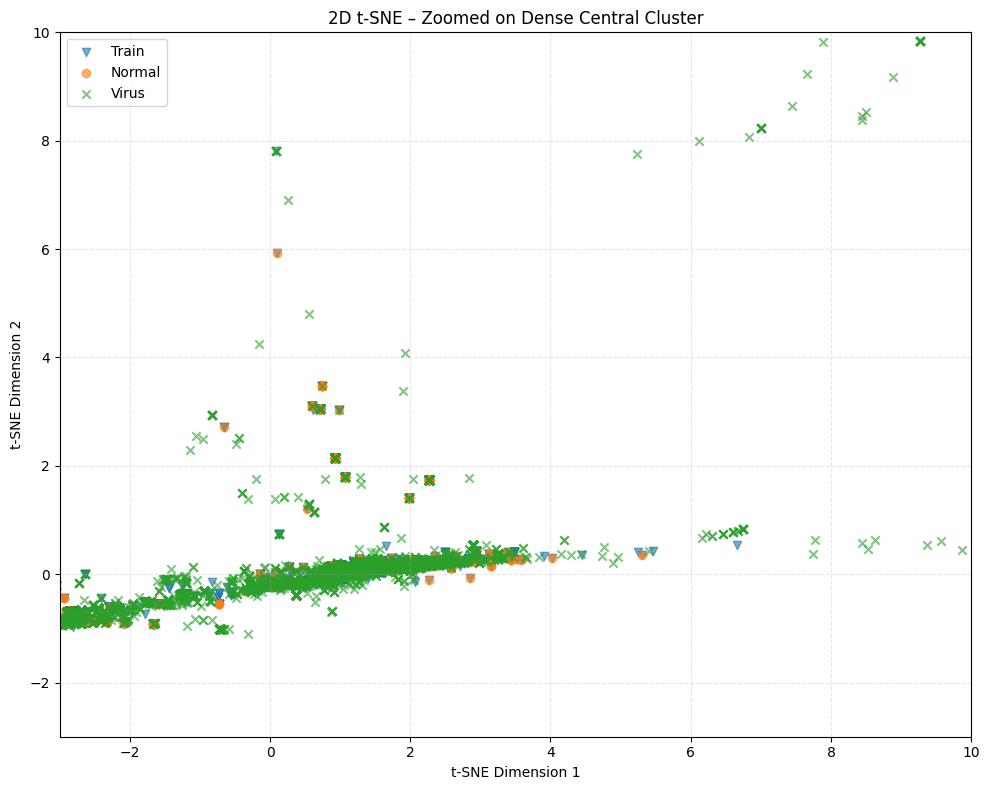

In [943]:
plt.figure(figsize=(10, 8))

plt.scatter(
    x_train_2d[:, 0], x_train_2d[:, 1],
    alpha=0.6, label="Train", marker="v"
)

plt.scatter(
    X_normal_2d[:, 0], X_normal_2d[:, 1],
    alpha=0.6, label="Normal", marker="o"
)

plt.scatter(
    X_virus_2d[:, 0], X_virus_2d[:, 1],
    alpha=0.6, label="Virus", marker="x"
)
plt.xlim(-3, 10)
plt.ylim(-3, 10)

plt.title("2D t-SNE – Zoomed on Dense Central Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: save high-resolution version
# plt.savefig("tsne_2d_zoomed.png", dpi=300, bbox_inches="tight")

plt.show()

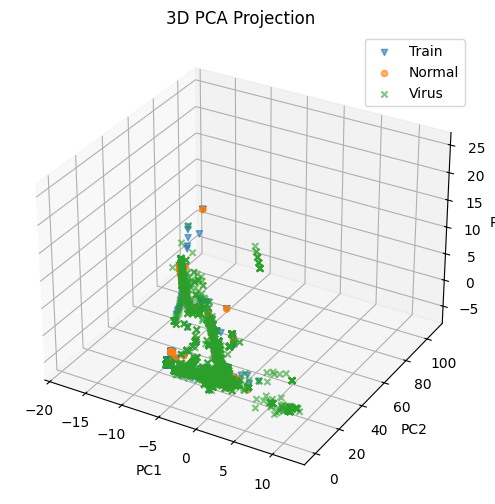

In [944]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=3)

x_train_3d   = pca.fit_transform( scaler.fit_transform(X_train) )
X_normal_3d  = pca.transform(scaler.transform(X_normal))
X_virus_3d   = pca.transform(scaler.transform(X_virus))

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x_train_3d[:, 0], x_train_3d[:, 1], x_train_3d[:, 2],
    alpha=0.6, label="Train", marker="v"
)

ax.scatter(
    X_normal_3d[:, 0], X_normal_3d[:, 1], X_normal_3d[:, 2],
    alpha=0.6, label="Normal", marker="o"
)

ax.scatter(
    X_virus_3d[:, 0], X_virus_3d[:, 1], X_virus_3d[:, 2],
    alpha=0.6, label="Virus", marker="x"
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection")

ax.legend()
plt.show()


/Users/igalmaman/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


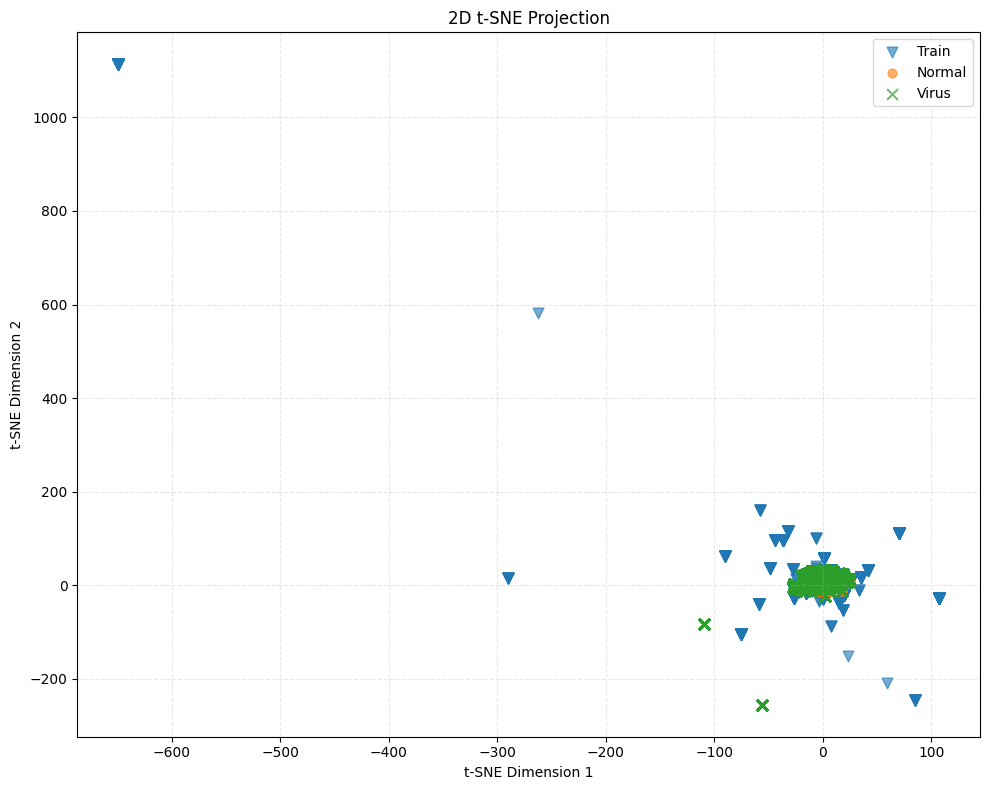

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Stack all data together
X_all = np.vstack([X_train, X_normal, X_virus])

labels = (
    ["Train"] * len(X_train) +
    ["Normal"] * len(X_normal) +
    ["Virus"] * len(X_virus)
)

# t-SNE to 2D
tsne = TSNE(
    n_components=2,           # ← changed to 2
    perplexity=30,
    n_iter=250,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_2d = tsne.fit_transform(X_all)

# Split back
i = 0
X_train_2d  = X_2d[i:i+len(X_train)];   i += len(X_train)
X_normal_2d = X_2d[i:i+len(X_normal)];  i += len(X_normal)
X_virus_2d  = X_2d[i:i+len(X_virus)]

# Plot in 2D
plt.figure(figsize=(10, 8))

plt.scatter(*X_train_2d.T,  alpha=0.6, label="Train",  marker="v", s=60)
plt.scatter(*X_normal_2d.T, alpha=0.6, label="Normal", marker="o", s=40)
plt.scatter(*X_virus_2d.T,  alpha=0.7, label="Virus",  marker="x", s=60)

plt.title("2D t-SNE Projection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

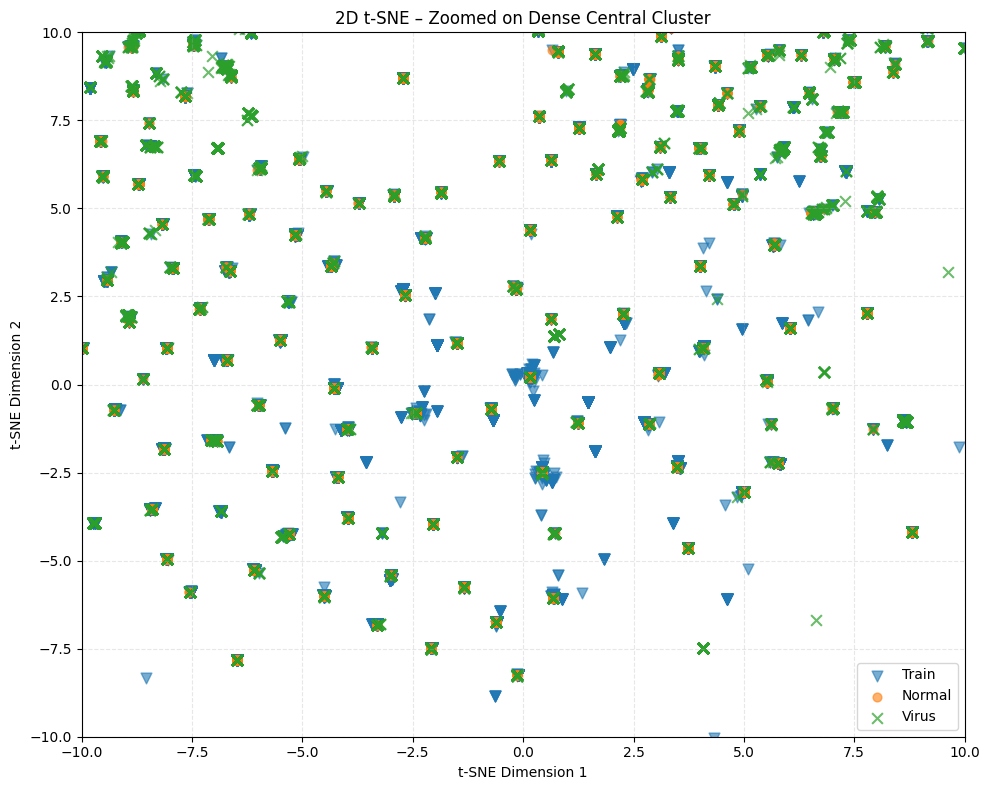

In [276]:
# Set zoom limits
plt.figure(figsize=(10, 8))

plt.scatter(*X_train_2d.T,  alpha=0.6, label="Train",  marker="v", s=60)
plt.scatter(*X_normal_2d.T, alpha=0.6, label="Normal", marker="o", s=40)
plt.scatter(*X_virus_2d.T,  alpha=0.7, label="Virus",  marker="x", s=60)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.title("2D t-SNE – Zoomed on Dense Central Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: save high-resolution version
# plt.savefig("tsne_2d_zoomed.png", dpi=300, bbox_inches="tight")

plt.show()

/var/folders/1j/84s7hv6954q6qnbwfszhtl8m0000gn/T/ipykernel_35903/627513424.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


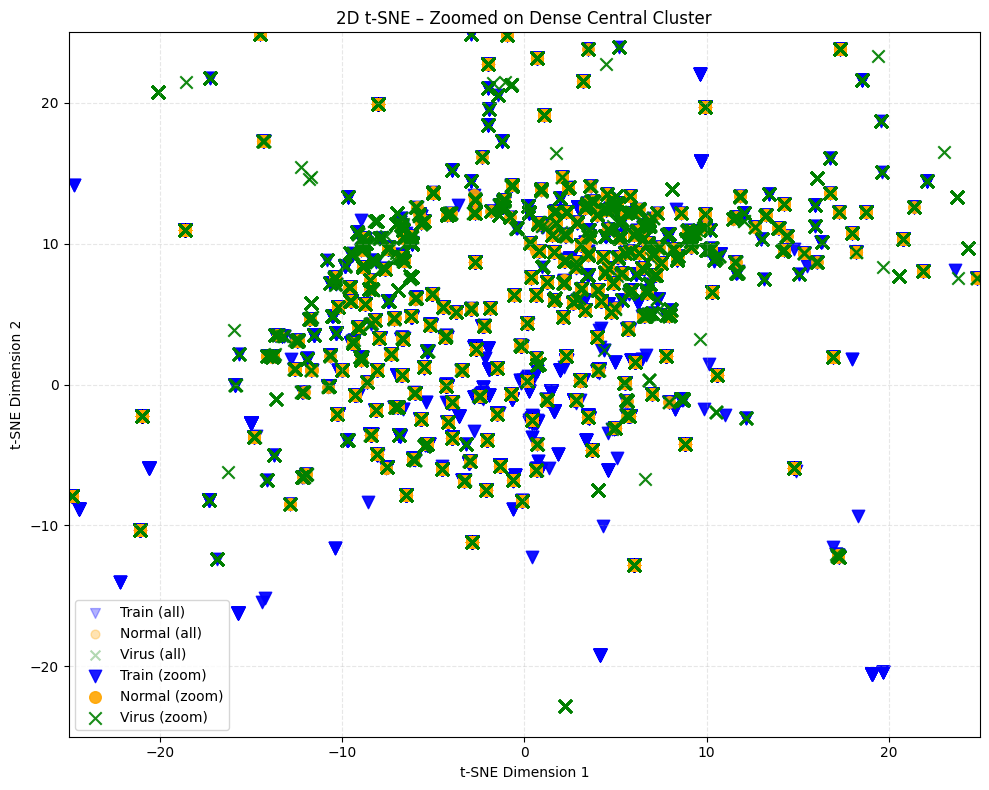

In [277]:
x_min, x_max = -25, 25    # zoom window – adjust as needed
y_min, y_max = -25, 25

# ────────────────────────────────────────────────
# Plot – zoomed version
# ────────────────────────────────────────────────
plt.figure(figsize=(10, 8))

# Plot all points but with low alpha for context
plt.scatter(
    X_train_2d[:, 0], X_train_2d[:, 1],
    c='blue', alpha=0.3, marker='v', s=50, label='Train (all)'
)
plt.scatter(
    X_normal_2d[:, 0], X_normal_2d[:, 1],
    c='orange', alpha=0.3, marker='o', s=40, label='Normal (all)'
)
plt.scatter(
    X_virus_2d[:, 0], X_virus_2d[:, 1],
    c='green', alpha=0.3, marker='x', s=50, label='Virus (all)'
)

# ────────────────────────────────────────────────
# Overlay higher-opacity points ONLY inside zoom window
# ────────────────────────────────────────────────
mask_train  = (X_train_2d[:,0]  >= x_min) & (X_train_2d[:,0]  <= x_max) & \
              (X_train_2d[:,1]  >= y_min) & (X_train_2d[:,1]  <= y_max)
mask_normal = (X_normal_2d[:,0] >= x_min) & (X_normal_2d[:,0] <= x_max) & \
              (X_normal_2d[:,1] >= y_min) & (X_normal_2d[:,1] <= y_max)
mask_virus  = (X_virus_2d[:,0]  >= x_min) & (X_virus_2d[:,0]  <= x_max) & \
              (X_virus_2d[:,1]  >= y_min) & (X_virus_2d[:,1]  <= y_max)

plt.scatter(
    X_train_2d[mask_train, 0], X_train_2d[mask_train, 1],
    c='blue', alpha=0.9, marker='v', s=80, label='Train (zoom)'
)
plt.scatter(
    X_normal_2d[mask_normal, 0], X_normal_2d[mask_normal, 1],
    c='orange', alpha=0.9, marker='o', s=70, label='Normal (zoom)'
)
plt.scatter(
    X_virus_2d[mask_virus, 0], X_virus_2d[mask_virus, 1],
    c='green', alpha=0.9, marker='x', s=80, label='Virus (zoom)'
)

# Set zoom limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("2D t-SNE – Zoomed on Dense Central Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: save high-resolution version
# plt.savefig("tsne_2d_zoomed.png", dpi=300, bbox_inches="tight")

plt.show()

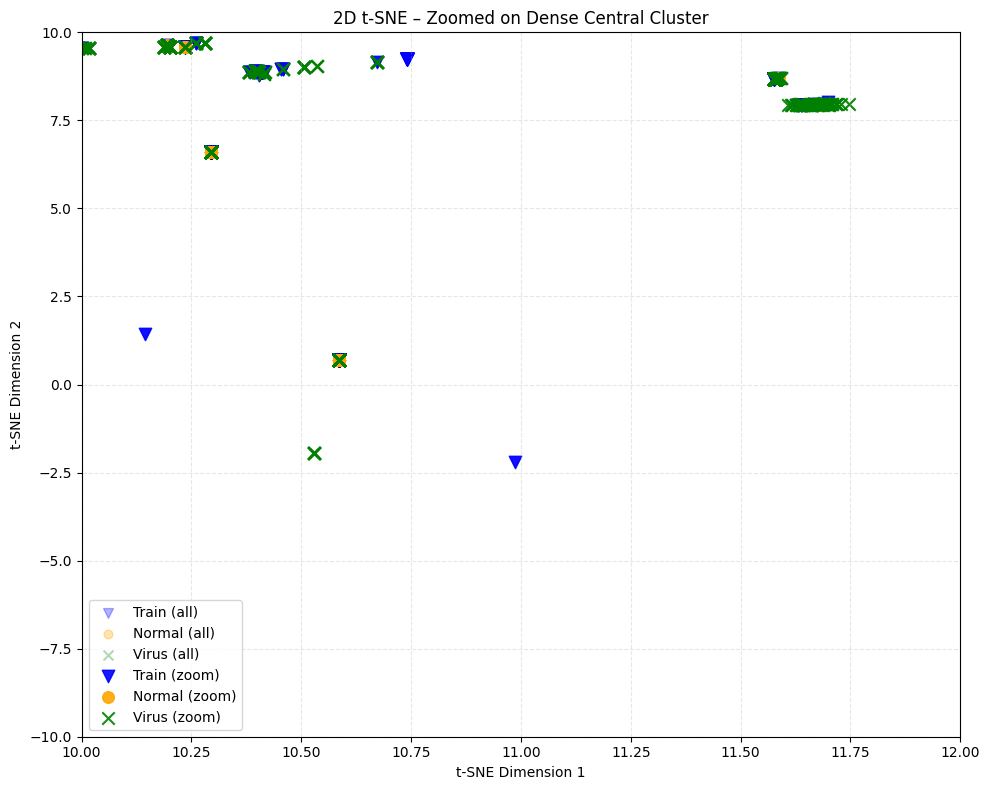

In [278]:
x_min, x_max = 10, 12    # zoom window – adjust as needed
y_min, y_max = -10, 10

# ────────────────────────────────────────────────
# Plot – zoomed version
# ────────────────────────────────────────────────
plt.figure(figsize=(10, 8))

# Plot all points but with low alpha for context
plt.scatter(
    X_train_2d[:, 0], X_train_2d[:, 1],
    c='blue', alpha=0.3, marker='v', s=50, label='Train (all)'
)
plt.scatter(
    X_normal_2d[:, 0], X_normal_2d[:, 1],
    c='orange', alpha=0.3, marker='o', s=40, label='Normal (all)'
)
plt.scatter(
    X_virus_2d[:, 0], X_virus_2d[:, 1],
    c='green', alpha=0.3, marker='x', s=50, label='Virus (all)'
)

# ────────────────────────────────────────────────
# Overlay higher-opacity points ONLY inside zoom window
# ────────────────────────────────────────────────
mask_train  = (X_train_2d[:,0]  >= x_min) & (X_train_2d[:,0]  <= x_max) & \
              (X_train_2d[:,1]  >= y_min) & (X_train_2d[:,1]  <= y_max)
mask_normal = (X_normal_2d[:,0] >= x_min) & (X_normal_2d[:,0] <= x_max) & \
              (X_normal_2d[:,1] >= y_min) & (X_normal_2d[:,1] <= y_max)
mask_virus  = (X_virus_2d[:,0]  >= x_min) & (X_virus_2d[:,0]  <= x_max) & \
              (X_virus_2d[:,1]  >= y_min) & (X_virus_2d[:,1]  <= y_max)

plt.scatter(
    X_train_2d[mask_train, 0], X_train_2d[mask_train, 1],
    c='blue', alpha=0.9, marker='v', s=80, label='Train (zoom)'
)
plt.scatter(
    X_normal_2d[mask_normal, 0], X_normal_2d[mask_normal, 1],
    c='orange', alpha=0.9, marker='o', s=70, label='Normal (zoom)'
)
plt.scatter(
    X_virus_2d[mask_virus, 0], X_virus_2d[mask_virus, 1],
    c='green', alpha=0.9, marker='x', s=80, label='Virus (zoom)'
)

# Set zoom limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("2D t-SNE – Zoomed on Dense Central Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: save high-resolution version
# plt.savefig("tsne_2d_zoomed.png", dpi=300, bbox_inches="tight")

plt.show()

/Users/igalmaman/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


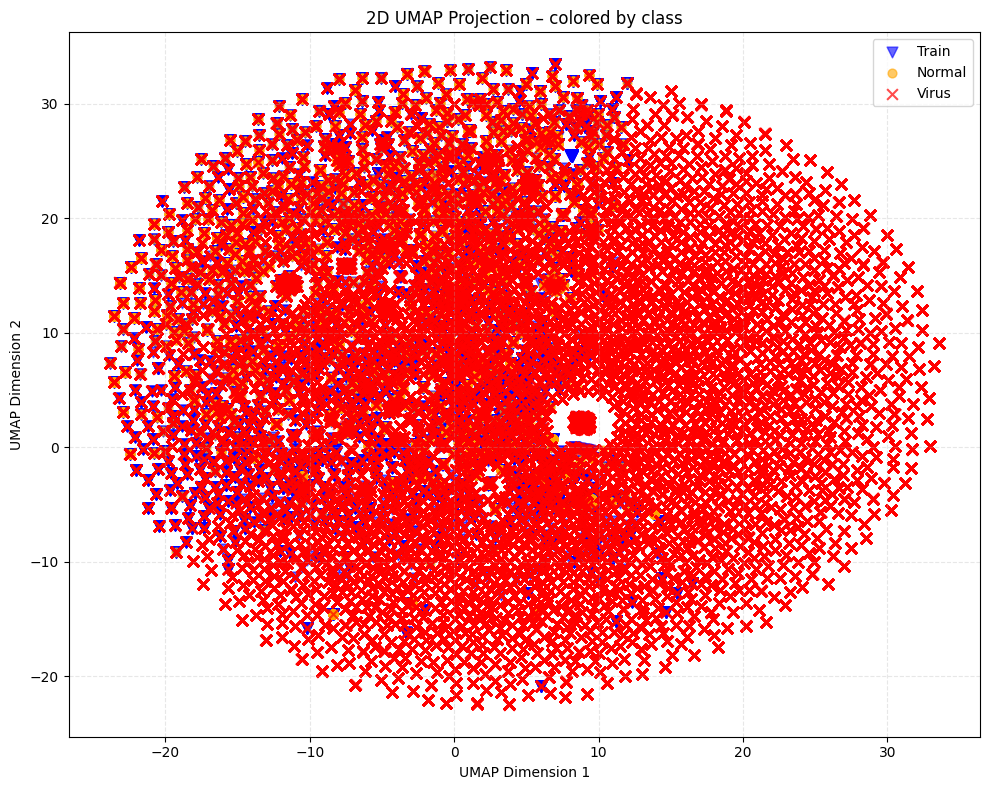

In [977]:
import numpy as np
import matplotlib.pyplot as plt
import umap  # pip install umap-learn if not already installed

# ────────────────────────────────────────────────
# Assume X_train, X_normal, X_virus are already defined
# (your original feature matrices – replace with your actual variables)
# ────────────────────────────────────────────────

# Stack all data together
X_all = np.vstack([X_train, X_normal, X_virus])

labels = (
    ["Train"]  * len(X_train) +
    ["Normal"] * len(X_normal) +
    ["Virus"]  * len(X_virus)
)

# UMAP to 2D
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,           # adjust 5–50 depending on how local/global you want
    min_dist=0.1,
    metric='euclidean',       # try 'cosine' for count/frequency data
    random_state=42,
    init='pca'                # often gives better starting layout
)

X_2d = reducer.fit_transform(X_all)

# Split back
i = 0
X_train_2d  = X_2d[i:i + len(X_train)];  i += len(X_train)
X_normal_2d = X_2d[i:i + len(X_normal)]; i += len(X_normal)
X_virus_2d  = X_2d[i:i + len(X_virus)]

# ────────────────────────────────────────────────
# Colored 2D plot
# ────────────────────────────────────────────────
plt.figure(figsize=(10, 8))

# Define colors and styles per class
colors = {
    'Train':  'blue',
    'Normal': 'orange',
    'Virus':  'red'
}

for label in ['Train', 'Normal', 'Virus']:
    mask = np.array(labels) == label
    
    plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        c=colors[label],
        alpha=0.7 if label == 'Virus' else 0.6,
        label=label,
        marker="v" if label == "Train" else "o" if label == "Normal" else "x",
        s=60 if label in ["Train", "Virus"] else 40
    )

plt.title("2D UMAP Projection – colored by class")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

plt.show()

/Users/igalmaman/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


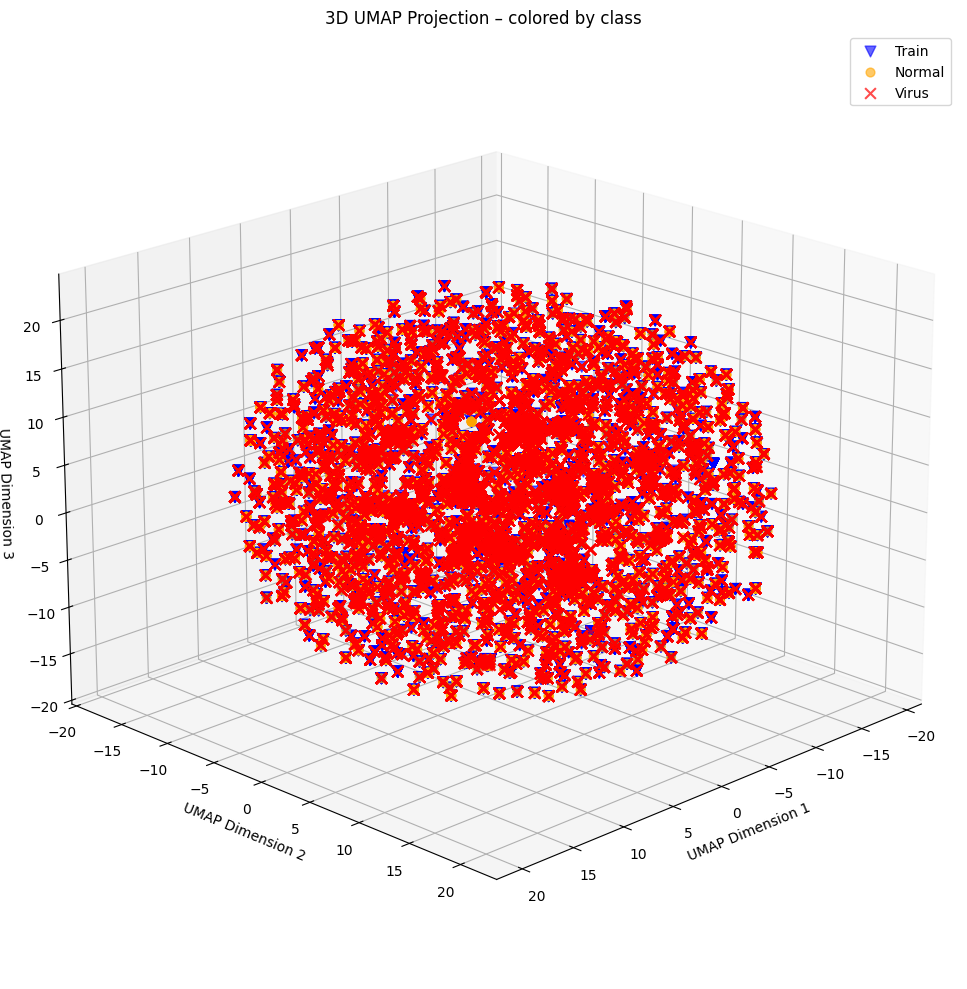

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap  # pip install umap-learn if not already installed

# ────────────────────────────────────────────────
# Assume X_train, X_normal, X_virus are already defined
# (your original feature matrices – replace with your actual variables)
# ────────────────────────────────────────────────

# Stack all data together
X_all = np.vstack([X_train, X_normal, X_virus])

labels = (
    ["Train"] * len(X_train) +
    ["Normal"] * len(X_normal) +
    ["Virus"] * len(X_virus)
)

# UMAP to 3D
reducer = umap.UMAP(
    n_components=3,           # ← changed to 3
    n_neighbors=15,           # adjust 5–50
    min_dist=0.1,
    metric='euclidean',       # try 'cosine' for count/frequency data
    random_state=42,
    init='pca'                # good starting point
)

X_3d = reducer.fit_transform(X_all)

# Split back
i = 0
X_train_3d  = X_3d[i:i + len(X_train)];  i += len(X_train)
X_normal_3d = X_3d[i:i + len(X_normal)]; i += len(X_normal)
X_virus_3d  = X_3d[i:i + len(X_virus)]

# ────────────────────────────────────────────────
# Colored 3D plot
# ────────────────────────────────────────────────
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors and styles per class
colors = {
    'Train':  'blue',
    'Normal': 'orange',
    'Virus':  'red'
}

for label in ['Train', 'Normal', 'Virus']:
    mask = np.array(labels) == label
    
    ax.scatter(
        X_3d[mask, 0],
        X_3d[mask, 1],
        X_3d[mask, 2],
        c=colors[label],
        alpha=0.7 if label == 'Virus' else 0.6,
        label=label,
        marker="v" if label == "Train" else "o" if label == "Normal" else "x",
        s=60 if label in ["Train", "Virus"] else 40
    )

ax.set_title("3D UMAP Projection – colored by class")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

ax.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: adjust viewing angle
ax.view_init(elev=20, azim=45)  # change these numbers to rotate view

# plt.savefig("umap_3d_colored.png", dpi=300, bbox_inches="tight")  # optional

plt.show()

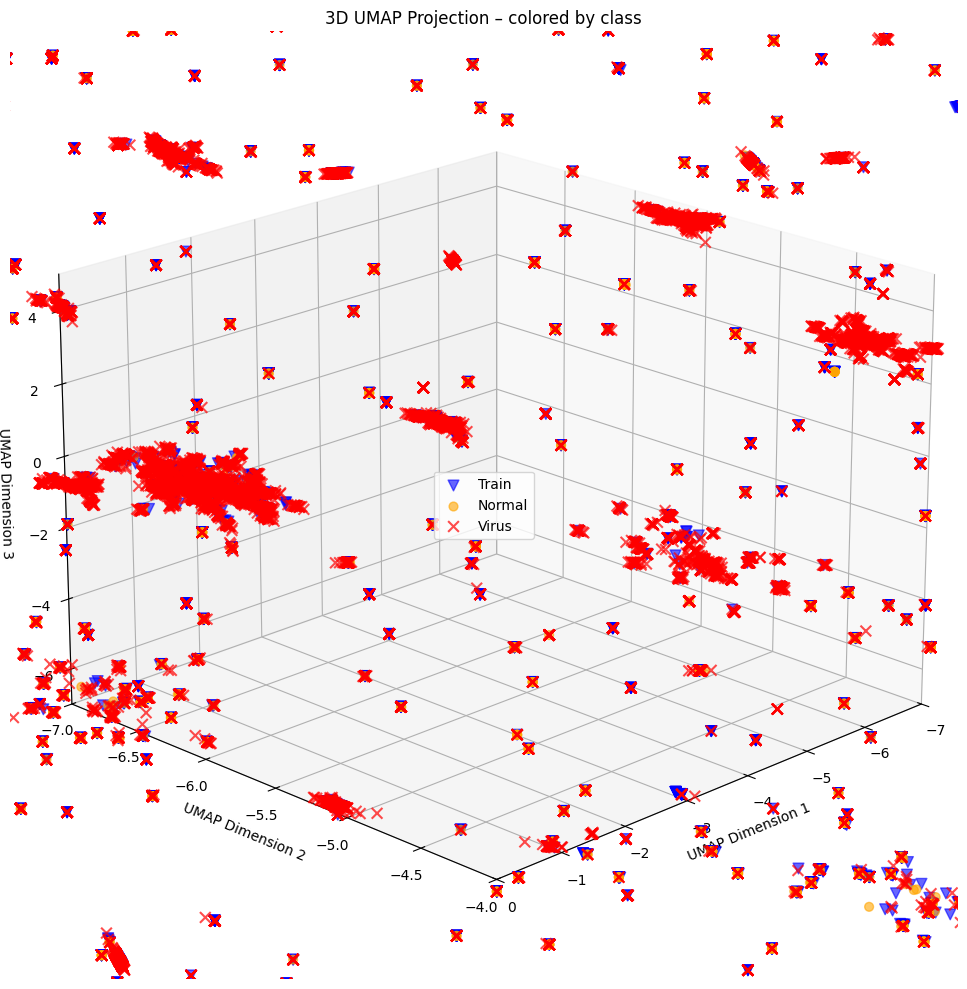

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-7, 0)   # example bounds — adjust after seeing data
ax.set_ylim(-7, -4)
ax.set_zlim(-7, 5)
# Define colors and styles per class
colors = {
    'Train':  'blue',
    'Normal': 'orange',
    'Virus':  'red'
}

for label in ['Train', 'Normal', 'Virus']:
    mask = np.array(labels) == label
    
    ax.scatter(
        X_3d[mask, 0],
        X_3d[mask, 1],
        X_3d[mask, 2],
        c=colors[label],
        alpha=0.7 if label == 'Virus' else 0.6,
        label=label,
        marker="v" if label == "Train" else "o" if label == "Normal" else "x",
        s=60 if label in ["Train", "Virus"] else 40
    )

ax.set_title("3D UMAP Projection – colored by class")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

ax.legend()
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

# Optional: adjust viewing angle
ax.view_init(elev=20, azim=45)  # change these numbers to rotate view

# plt.savefig("umap_3d_colored.png", dpi=300, bbox_inches="tight")  # optional

plt.show()

In [61]:
from collections import defaultdict
import robocop

def evaluate_and_report(label: str, windows, X, model, scaler):
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled)                 # +1 normal, -1 anomaly
    scores = model.decision_function(X_scaled)      # more negative => more anomalous
    
    # Use a dictionary to aggregate by ID
    aggregated_results = {} 

    for i, (p, s) in enumerate(zip(preds, scores)):
        if p != -1:
            continue
        
        w = windows[i]
        # Assuming all events in the window have the same metadata
        event_id = w[0]["id"]
        proc_name = w[0]["process_name"]
        pid = w[0]["pid"]
        syscalls = [robocop.convert_syscall_num_to_string(e["syscall_num"]) for e in w]

        if event_id not in aggregated_results:
            aggregated_results[event_id] = {
                "id": event_id,
                "pid": pid,
                "name": proc_name,
                "score": 0.0,          # Initialize score for summation
                "syscalls": set()      # Use a set to avoid duplicate strings in aggregation
            }
        
        # Aggregate logic
        aggregated_results[event_id]["score"] += float(s)
        # Update syscall list (adding unique syscalls seen in this specific window)
        aggregated_results[event_id]["syscalls"].update(syscalls)

    # Convert the dictionary back to a list and convert sets back to lists
    final_report = []
    for entry in aggregated_results.values():
        entry["syscalls"] = list(entry["syscalls"])
        final_report.append(entry)

    return final_report

In [62]:
from collections import defaultdict
import robocop

def evaluate_and_report_valid(label: str, windows, X, model, scaler):
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled)                 # +1 normal, -1 anomaly
    scores = model.decision_function(X_scaled)      # more negative => more anomalous
    
    # Use a dictionary to aggregate by ID
    aggregated_results = {} 

    for i, (p, s) in enumerate(zip(preds, scores)):
        if p != 1:
            continue
        
        w = windows[i]
        # Assuming all events in the window have the same metadata
        event_id = w[0]["id"]
        proc_name = w[0]["process_name"]
        pid = w[0]["pid"]
        syscalls = [robocop.convert_syscall_num_to_string(e["syscall_num"]) for e in w]

        if event_id not in aggregated_results:
            aggregated_results[event_id] = {
                "id": event_id,
                "pid": pid,
                "name": proc_name,
                "score": 0.0,          # Initialize score for summation
                "syscalls": set()      # Use a set to avoid duplicate strings in aggregation
            }
        
        # Aggregate logic
        aggregated_results[event_id]["score"] += float(s)
        # Update syscall list (adding unique syscalls seen in this specific window)
        aggregated_results[event_id]["syscalls"].update(syscalls)

    # Convert the dictionary back to a list and convert sets back to lists
    final_report = []
    for entry in aggregated_results.values():
        entry["syscalls"] = list(entry["syscalls"])
        final_report.append(entry)

    return final_report

In [63]:
import matplotlib.pyplot as plt

def plot_process_all_scores(results, process_name):
    scores = [r["score"] for r in results if r["name"] == process_name]

    if not scores:
        print(f"No scores found for process: {process_name}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(scores, marker='o')
    plt.axhline(0, linestyle="--")

    plt.title(f"OCSVM scores for process: {process_name}")
    plt.xlabel("Window index")
    plt.ylabel("OCSVM score (lower = more anomalous)")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel="rbf", nu=0.05, gamma=0.001)
model.fit(X_train_scaled)


OneClassSVM(gamma=0.001, nu=0.05)

In [ ]:
normal_report_x = evaluate_and_report(
    label="NORMAL",
    windows=normla_mapping,
    X=X_normal,
    model=model,
    scaler=scaler
)
virus_report_x = evaluate_and_report(
    label="VIRUS",
    windows=virus_mapping,
    X=X_virus,
    model=model,
    scaler=scaler
)
print(f"NU : VIRUS:{len(virus_report_x)} NORMAL:{len(normal_report_x)}")

NU : VIRUS:12896 NORMAL:218


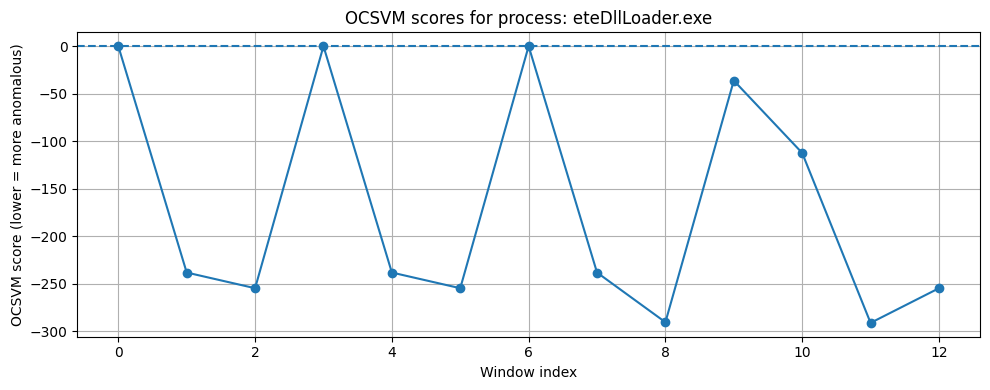

In [ ]:
plot_process_all_scores(virus_report_x,'eteDllLoader.exe')

In [ ]:
plot_process_all_scores(normal_report_x,'efox\\firefox.exe')

No scores found for process: efox\firefox.exe


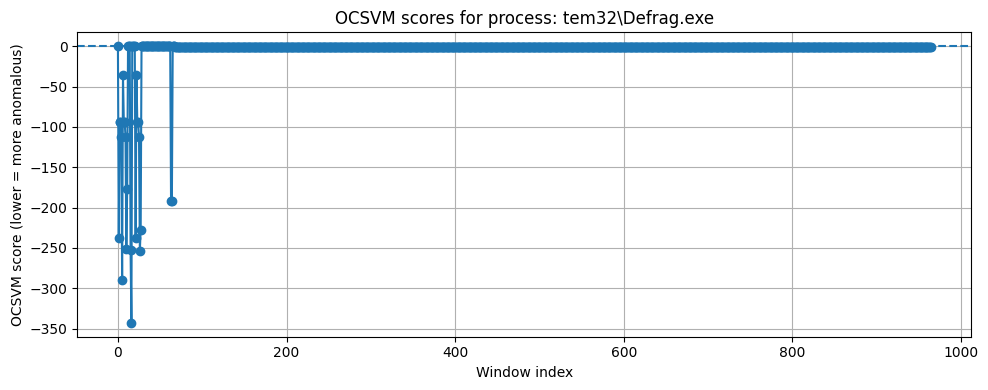

In [ ]:
plot_process_all_scores(virus_report_x, 'tem32\\Defrag.exe')

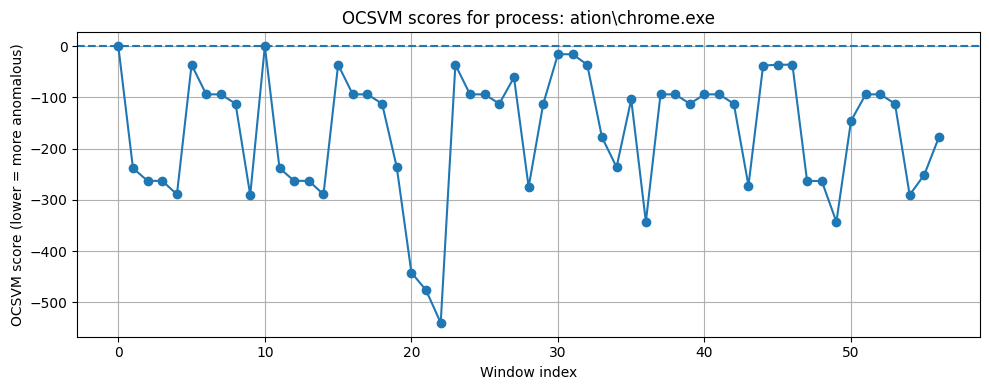

In [ ]:
plot_process_all_scores(normal_report_x, 'ation\chrome.exe')

In [ ]:
plot_process_all_scores(normal_report_x, 'fa0\TiWorker.exe')

No scores found for process: fa0\TiWorker.exe


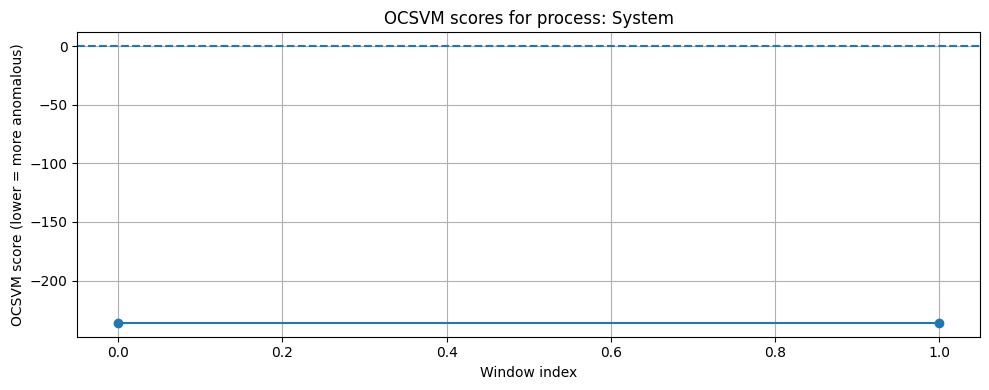

In [ ]:

plot_process_all_scores(normal_report_x, 'System')

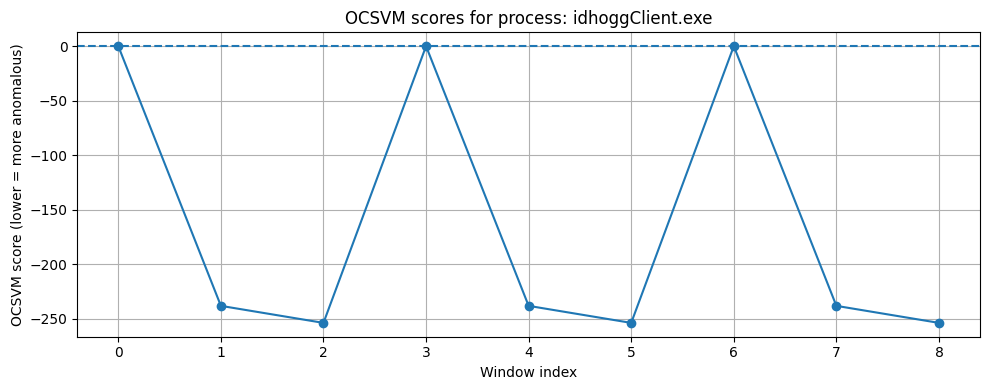

In [ ]:
plot_process_all_scores(virus_report_x, 'idhoggClient.exe') # We missed it! it is not so sus this is good!

In [ ]:
plot_process_all_scores(virus_report_x, 'm32\rundll32.exe')

undll32.exeound for process: m32


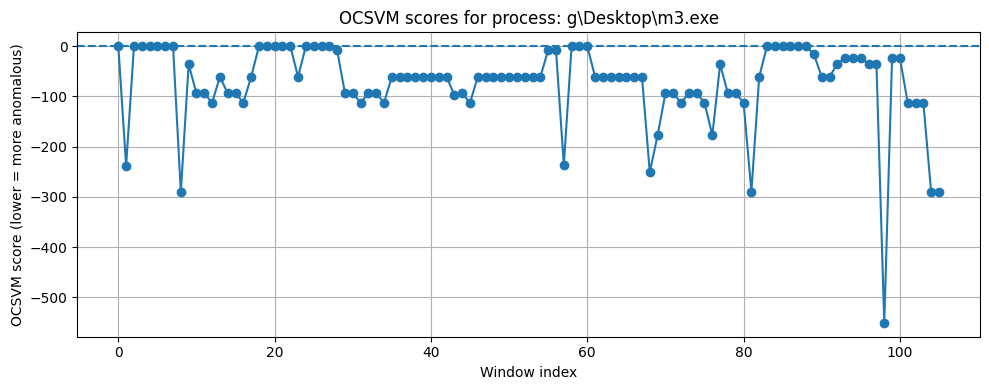

In [ ]:
plot_process_all_scores(virus_report_x, 'g\Desktop\m3.exe')

In [ ]:
open("Virus_report_svm.json",'w').write(json.dumps(virus_report_x))

2078372

In [945]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Scaling (Isolation Forest does NOT strictly require scaling,
# but keeping it is fine for consistency)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

# Isolation Forest
model2 = IsolationForest(
    n_estimators=300,
    contamination=0.05,   # expected fraction of anomalies
    random_state=40,
    n_jobs=-5,
)

model2.fit(X_train_scaled)

IsolationForest(contamination=0.05, n_estimators=300, n_jobs=-5,
                random_state=40)

In [946]:
normal_report = evaluate_and_report(
    label="NORMAL",
    windows=normla_mapping,
    X=X_normal,
    model=model2,
    scaler=scaler
)

virus_report = evaluate_and_report(
    label="VIRUS",
    windows=virus_mapping,
    X=X_virus,
    model=model2,
    scaler=scaler
)
print(f"NU : VIRUS:{len(virus_report)} NORMAL:{len(normal_report)}")

NU : VIRUS:843 NORMAL:58


In [947]:
virus_report_filtered = [i for i in virus_report if abs(i["score"]) >= 0.03]

In [948]:
len(virus_report_filtered)

437

In [949]:
normal_report_filtered = [i for i in normal_report if abs(i["score"]) >= 0.03]

In [950]:
len(normal_report_filtered)

18

In [976]:
plot_process_all_scores(normal_report_filtered,'efox\\firefox.exe')

No scores found for process: efox\firefox.exe


In [975]:
plot_process_all_scores(virus_report_filtered, 'g\Desktop\m3.exe')

No scores found for process: g\Desktop\m3.exe


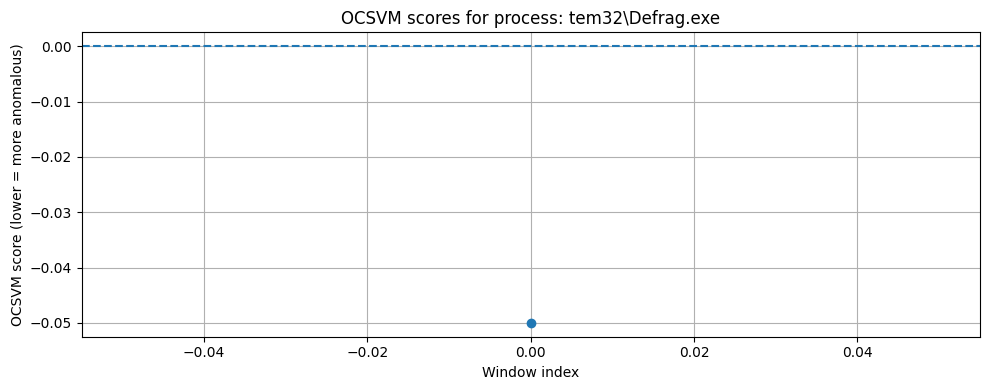

In [953]:
plot_process_all_scores(virus_report_filtered, 'tem32\\Defrag.exe')

In [974]:
plot_process_all_scores(virus_report_filtered,'eteDllLoader.exe')

No scores found for process: eteDllLoader.exe


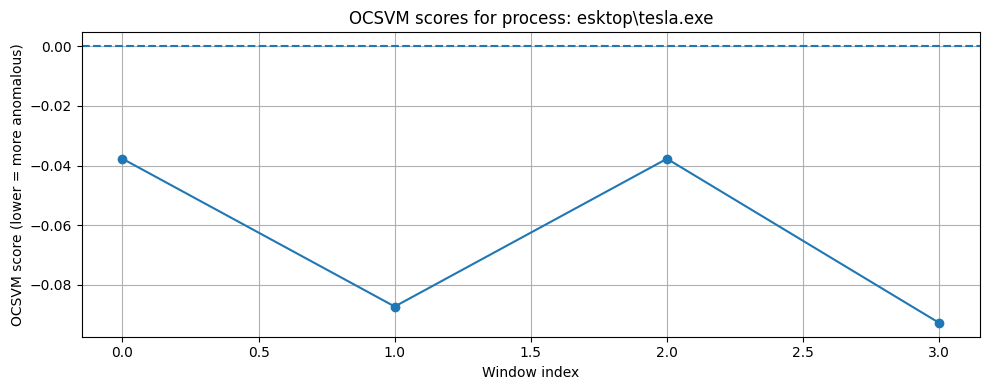

In [955]:
plot_process_all_scores(virus_report_filtered,'esktop\\tesla.exe')

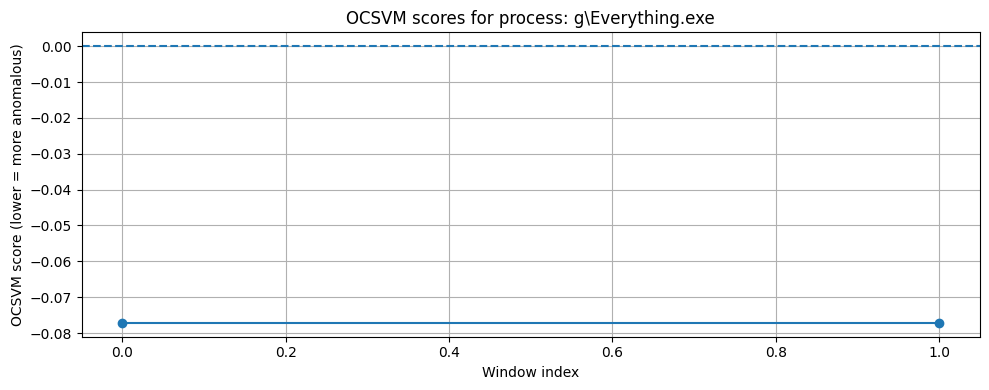

In [956]:
plot_process_all_scores(virus_report_filtered,"g\\Everything.exe") 

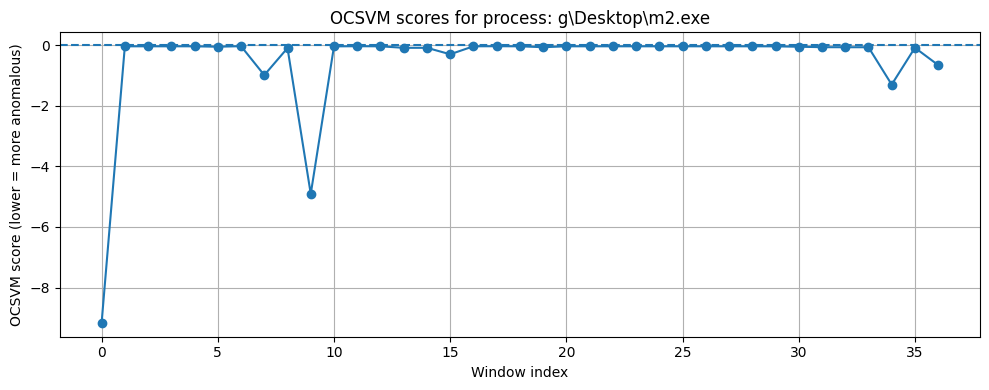

In [957]:
plot_process_all_scores(virus_report_filtered,"g\\Desktop\\m2.exe") 

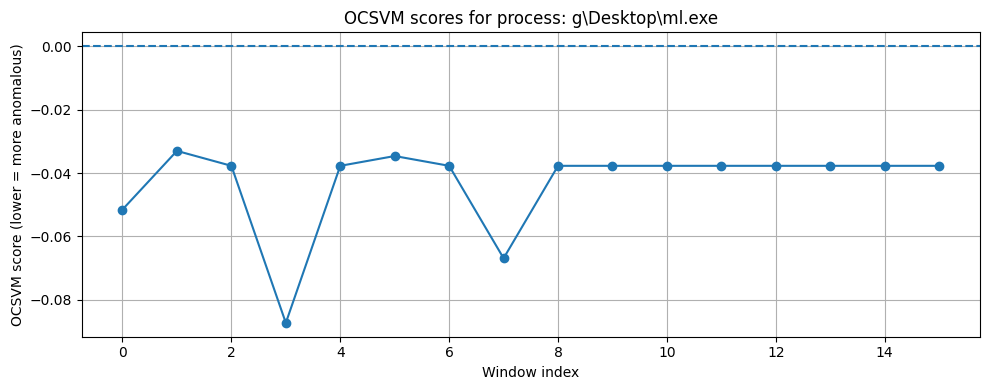

In [958]:
plot_process_all_scores(virus_report_filtered,"g\\Desktop\\ml.exe") 

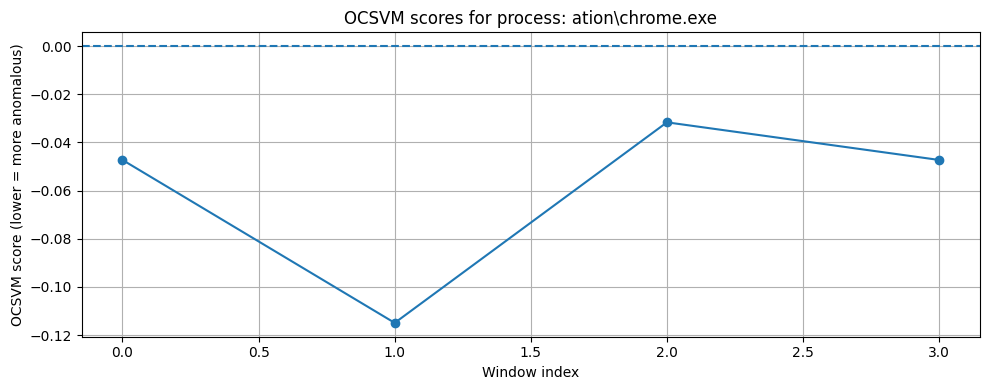

In [959]:
plot_process_all_scores(normal_report_filtered, 'ation\chrome.exe')

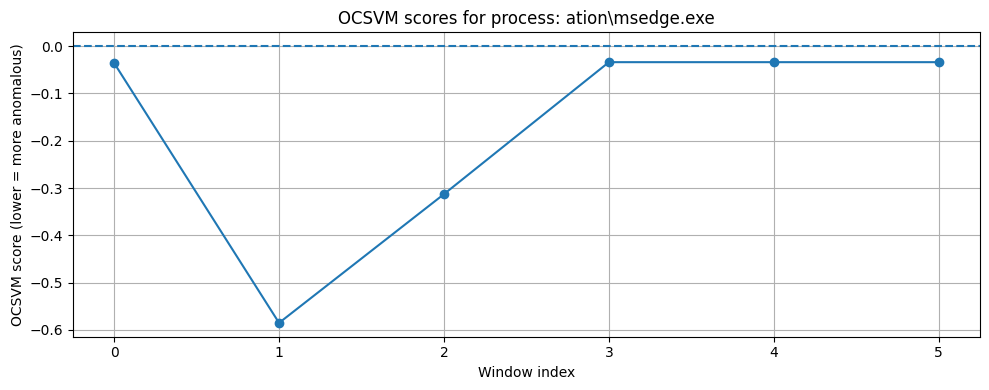

In [960]:
plot_process_all_scores(virus_report_filtered,"ation\\msedge.exe")

In [961]:
open("Virus_report.json",'w').write(json.dumps(virus_report_filtered))

79418

In [39]:
open("Normal_report.json",'w').write(json.dumps(normal_report))

124957

In [246]:
def test_attack_scenarios(clf,test):
    print(f"{'Attack Name':<30} | {'Anomaly Score':<15} | {'Verdict'}")
    print("-" * 60)
    for name, window in test.items():
        trigger_id = window[0][0] 
        print(window)
        features = extract_features(window, trigger_id)
        score = clf.score_samples([features])[0]
        verdict = "MALICIOUS[X]" if score < 0 else "NORMAL[O]"
        
        print(f"{name:<30} | {score:<15.4f} | {verdict}")

In [248]:
from time import time
ATTACK_SCENARIOS = {
    "DLL Injection (Classic)": [
        (38, 0), # NtOpenProcess
        (24, 0), # NtAllocateVirtualMemory (Private Mem)
        (58, 0), # NtWriteVirtualMemory
        (194, 0)  # NtCreateThreadEx
    ],
    "Process Doppelganging": [
        (199, 0), # NtCreateTransaction (TX category)
        (51, 0), # NtOpenFile (on a clean file to ghost)
        (74, 0), # NtCreateSection (memory_image)
        (388, 0)  # NtRollbackTransaction
    ],
    "Atom Bombing": [
        (105, 0), # NtAddAtom (Registry/Global space)
        (37, 0), # NtQueryInformationThread
        (358, 0)  # NtQueueApcThread
    ],
    "Pool Party (Thread Pool Injection)": [
        (419, 0), # NtSetInformationWorkerFactory
        (144, 0), # NtAssociateWaitCompletionPacket
        (372, 0)  # NtReleaseWorkerFactoryWorker
    ],
    "DLL Hollowing": [
        (74, 0), # NtCreateSection (Memory Image)
        (40, 0), # NtMapViewOfSection
        (42, 0), # NtUnmapViewOfSection
        (82, 0)  # NtResumeThread
    ], 
}
test_attack_scenarios(model2,ATTACK_SCENARIOS)

Attack Name                    | Anomaly Score   | Verdict
------------------------------------------------------------
[(38, 0), (24, 0), (58, 0), (194, 0)]
DLL Injection (Classic)        | -0.4088         | MALICIOUS[X]
[(199, 0), (51, 0), (74, 0), (388, 0)]
Process Doppelganging          | -0.4133         | MALICIOUS[X]
[(105, 0), (37, 0), (358, 0)]
Atom Bombing                   | -0.3920         | MALICIOUS[X]
[(419, 0), (144, 0), (372, 0)]
Pool Party (Thread Pool Injection) | -0.4085         | MALICIOUS[X]
[(74, 0), (40, 0), (42, 0), (82, 0)]
DLL Hollowing                  | -0.4215         | MALICIOUS[X]


In [968]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Scaling (Isolation Forest does NOT strictly require scaling,
# but keeping it is fine for consistency)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

# Isolation Forest
model3 = IsolationForest(
    n_estimators=300,
    contamination=0.30,   # expected fraction of anomalies
    random_state=50,
    n_jobs=-5,
    bootstrap=True,
    max_samples='auto'
)

model3.fit(X_train_scaled)

IsolationForest(bootstrap=True, contamination=0.3, n_estimators=300, n_jobs=-5,
                random_state=50)

In [969]:
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=virus_mapping,
    X=X_virus,
    model=model3,
    scaler=scaler
)

In [970]:
len(virus_report)

6908

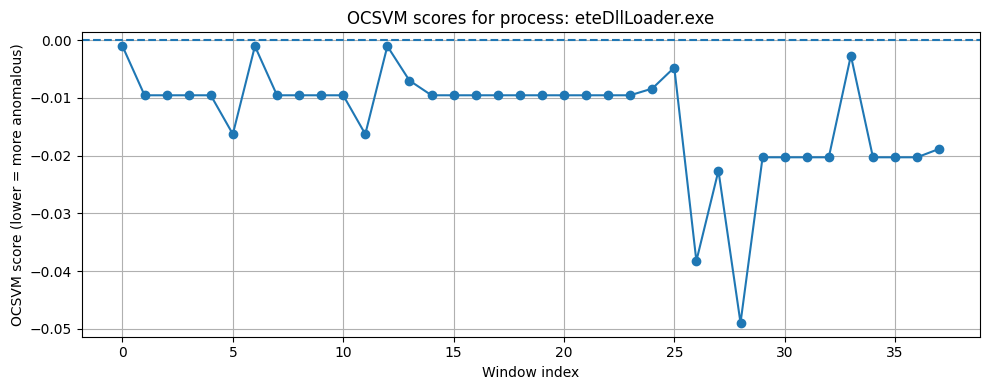

In [971]:
plot_process_all_scores(virus_report,'eteDllLoader.exe')

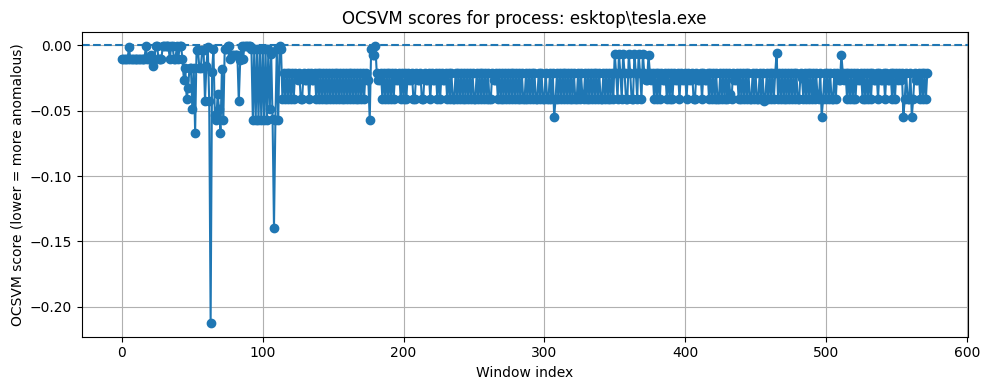

In [972]:
plot_process_all_scores(virus_report,'esktop\\tesla.exe')

In [973]:
open("Virus_report.json",'w').write(json.dumps(virus_report))

1177217

In [282]:
with open("train.json",'w') as file: 
    json.dump(train_events,file)

In [283]:
with open("virus.json",'w') as file: 
    json.dump(virus_events,file)

In [284]:
with open("normal.json",'w') as file: 
    json.dump(normal_events,file)